In [113]:
import numpy as np
import pandas as pd
import os
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
from scipy.stats import norm
from tabulate import tabulate

In [21]:
def get_close_price(ticker, period="max"):
    """Запрос исторических данных о цене закрытия по тикеру
    Варианты написания периода: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max"""
    ticker_base_info = yf.Ticker(ticker)
    hist = ticker_base_info.history(period="max")
    close = np.array(hist.iloc[:,3])
    return close

In [28]:
def calc_rate_of_return(close_prices_array):
    """Расчет доходности по акциям на основании массива цен закрытия"""
    ror = np.diff(close) / close[:-1]
    return ror

In [37]:
def calc_acc_rate_of_return(rate_of_return_array):
    """Расчет накопленной доходности на основании массива значений доходности"""
    aror = (ror + 1.).cumprod() - 1
    return aror

In [41]:
def calc_compound_annual_growth_rate(acc_rate_of_return_array):
    """Расчет среднегодовой доходности на основании массива значений накопленной доходности"""
    years_total = acc_rate_of_return_array.size / 12
    cagr = (aror[-1] + 1.) ** (1 / years_total) - 1.
    return cagr

In [45]:
def calc_risk_monthly(rate_of_return_array):
    """Расчет месячного риска на основании массива значений доходности"""
    risk_monthly = rate_of_return_array.std()
    return risk_monthly

In [46]:
def calc_risk_yearly(rate_of_return_array):
    """Расчет годового риска на основании массива значений доходности"""
    ror_mean = (1. + rate_of_return_array).mean()
    risk_monthly = calc_risk_monthly(rate_of_return_array)
    risk_yearly = np.sqrt((risk_monthly**2 + ror_mean**2)**12 - ror_mean**24)
    return risk_yearly

In [75]:
def calc_rate_of_return_p(ticker_list, weights):
    """Расчет доходности по активам портфеля"""
    ror_p = 0.0
    for i in range(weights.size):
        close = get_close_price(ticker_list[i])
        ror = calc_rate_of_return(close) * weights[i]
        ror_sum = ror.sum(axis=0)
        ror_p = ror_p + ror_sum
    return ror_p

In [121]:
def plot_var(rate_of_return_array):
    """Расчет показателя Value at Risk"""
    ror_mean = np.mean(ror)
    ror_std = np.std(ror)
    pd.Series(ror).hist(bins=40, density=True,histtype='stepfilled',alpha=0.5)
    #x = np.linespace(ror_mean - 3 * ror_std, ror_mean + 3 * ror_std, 100)
    #plt.plot(x,mlab.normpdf(x, ror_mean, ror_std),"r")
    var_90 = norm.ppf(1-0.9,ror_mean,ror_std)
    var_95 = norm.ppf(1-0.95,ror_mean,ror_std)
    var_99 = norm.ppf(1-0.99,ror_mean,ror_std)
    print(tabulate([['90%',var_90],['95%',var_95],['99%',var_99]],headers=['Confidence Level', 'Value at Risk']))
    plt.show()

In [127]:
def calc_var(rate_of_return_array, alpha = 0.95):
    sorted_df = pd.Series(rate_of_return_array).sort_values(ascending = True)
    VaR = sorted_df.quantile(q=alpha, interpolation = 'higher')
    return VaR

In [132]:
def calc_esf(rate_of_return_array, alpha = 0.95):
    sorted_df = pd.Series(rate_of_return_array).sort_values(ascending = True)
    VaR = calc_var(sorted_df, alpha = alpha )
    Multipler = 1/(len(sorted_df)*(1-alpha))
    FirstTerm = VaR
    SecondTerm = (sorted_df.searchsorted(VaR)[0]+1) - len(sorted_df)*alpha 
    #SecondTerm = 1
    ThirdTerm = sum(sorted_df[sorted_df > VaR])
    ES = Multipler *(FirstTerm * SecondTerm + ThirdTerm)
    return ES

In [ ]:
close = get_close_price('MSFT','2y')
ror = calc_rate_of_return(close)

In [42]:
aror = calc_acc_rate_of_return(ror)

In [43]:
cagr = calc_compound_annual_growth_rate(aror)

In [47]:
risk_monthly = calc_risk_monthly(ror)

In [49]:
risk_yearly = calc_risk_yearly(ror)

In [117]:
print(cagr)

0.008504886345628293


In [118]:
print(risk_yearly)

0.12487801106793742


In [133]:
calc_var(ror)

0.03840814437760305

In [ ]:
calc_esf(ror)

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0286972
95%                      -0.037174
99%                      -0.0530751


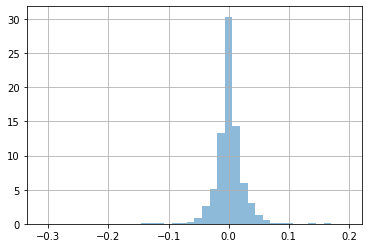

In [122]:
plot_var(ror)

In [119]:
weights = np.array([0.5,0.5])
ticker_list = ['MSFT','AAPL']
calc_rate_of_return_p(ticker_list, weights)

10.553055331073287